In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import warnings
warnings.simplefilter("ignore")

RANDOM_SEED = 20090425

## Convergence Diagnostics

There are a handful of easy-to-use methods for checking convergence. Since you cannot prove convergence, but only show lack of convergence, there is no single method that is foolproof. So, its best to look at a suite of diagnostics together. 

We will cover the canonical set of checks:

- Traceplot
- Divergences
- R-hat
- Effective Sample Size

## Traceplot 

This is a simple plot that is a good quick check to make sure nothing is obviously wrong, and is usually the first diagnostic step you will take. You've seen these already: just the time series of samples for an individual variable.

Let's run the PKU model again as an example:

In [2]:
pku_data = pd.read_csv('../data/pku_data.csv')

unique_papers = set(pku_data['Paper ID'])
paper_map = {p:i for i,p in enumerate(unique_papers)}
paper_id = pku_data['Paper ID'].replace(paper_map)
phe_std = ((pku_data.Phe - pku_data.Phe.mean()) / pku_data.Phe.std()).values
iq = pku_data['IQ'].values
concurrent_measurement = pku_data['Concurrent'].values

In [3]:
with pm.Model() as pku_model:

    μ_int = pm.Normal('μ_int', mu=100, sigma=1e3)
    σ_int = pm.HalfCauchy('σ_int', beta=5)
    β_0 = pm.Normal('β_0', μ_int, sigma=σ_int, shape=len(unique_papers))
    β_1 = pm.Normal('β_1', mu=0, sigma=1e3)
    β_2 = pm.Normal('β_2', mu=0, sigma=1e3)

    μ_iq = β_0[paper_id] + β_1*phe_std + β_2*concurrent_measurement

    σ_iq = pm.HalfCauchy('σ_iq', beta=1)
    iq_like = pm.Normal('iq_like', mu=μ_iq, sigma=σ_iq, observed=iq)

In [4]:
with pku_model:

    pku_trace = pm.sample(500, tune=0, step=pm.Metropolis(), return_inferencedata=True, random_seed=RANDOM_SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [σ_iq]
>Metropolis: [β_2]
>Metropolis: [β_1]
>Metropolis: [β_0]
>Metropolis: [σ_int]
>Metropolis: [μ_int]


Sampling 2 chains for 0 tune and 500 draw iterations (0 + 1_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The `plot_trace` function from ArViZ by default generates a kernel density plot and a trace plot, with a different color for each chain of the simulation.

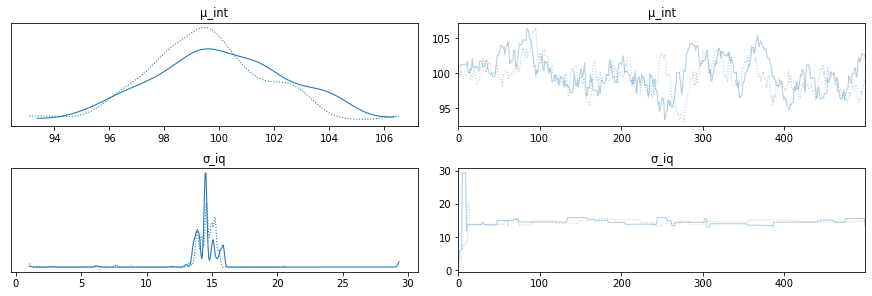

In [5]:
with pku_model:
    az.plot_trace(pku_trace, var_names=['μ_int', 'σ_iq']);

This sample is deliberately inadequate. Looking at the trace plot, the problems should be apparent.

Can you identify the issues, based on what you learned in the previous section?

### Exercise: Take a quiz!

[See how well you can identify sampling problems by looking at their traceplots](https://canyon289.github.io/bayesian-model-evaluation/lessonplans/mcmc_basics/#/14)

The slides will show you a trace, and you have to guess whether the sampling is from one of:

- MCMC with step size too small
- MCMC with step size too large
- MCMC with adequate step size
- Independent samples from distribution

## Divergences

As we have seen, Hamiltonian Monte Carlo (and NUTS) performs numerical integration in order to explore the posterior distribution of a model. When the integration goes wrong, it can go dramatically wrong. 

For example, here are some Hamiltonian trajectories on the distribution of two correlated variables. Can you spot the divergent path?

![divering HMC](images/diverging_hmc.png)

The reason that this happens is that there may be parts of the posterior which are **hard to explore** for geometric reasons. Two ways of solving divergences are

1. **Set a higher "target accept" rate**: Similarly (but not the same) as for Metropolis-Hastings, larger integrator steps lead to lower acceptance rates. A higher `target_accept` will generally cause a smaller step size, and more accurate integration.
2. **Reparametrize**: If you can write your model in a different way that has the same joint probability density, you might do that. A lot of work is being done to automate this, since it requires careful work, and one goal of a probabilistic programming language is to iterate quickly. See [Hoffmann, Johnson, Tran (2018)](https://arxiv.org/abs/1811.11926), [Gorinova, Moore, Hoffmann (2019)](https://arxiv.org/abs/1906.03028), and there is work on this also in [symbolic pymc](https://github.com/pymc-devs/symbolic-pymc).

You should be wary of a trace that contains many divergences (particularly those clustered in particular regions of the parameter space), and give thought to how to fix them.

### Divergence example

The trajectories above are from a famous example of a difficult geometry: Neal's funnel. It is problematic because the geometry is very different in some regions of the state space relative to others. Specifically, for hierarchical models, as the scale parameter changes in size so do the values of the parameters it is constraining. When the variance is close to zero, the parameter space is very constrained relative to the majority of the support.

In [6]:
def neals_funnel(dims=1):
    with pm.Model() as funnel:
        v = pm.Normal('v', 0, 3)
        x_vec = pm.MvNormal('x_vec', mu=tt.zeros(dims), cov=2 * tt.exp(v) * tt.eye(dims), shape=dims)
    return funnel

with neals_funnel() as neals_funnel_1:
    funnel_trace = pm.sample(random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_vec, v]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 292 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5139882545170171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6024904223610484, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


PyMC3 provides us feedback on divergences, including a count and a recommendation on how to address them. 

In [7]:
funnel_trace.sample_stats

diverging_ind = np.where(funnel_trace.sample_stats.diverging)
diverging_ind

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 

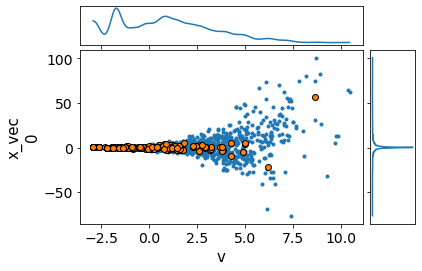

In [8]:
with neals_funnel_1:
    ax, *_ = az.plot_pair(
        funnel_trace, 
        divergences=True,
        marginals=True,
    );

Let's look at an example of this using the radon example from the first section. Specifically, we will run the random-slopes model, which has a hierarchical model for the basement effect or radon measurements.

In [9]:
# Import radon data
radon_data = pd.read_csv('../data/radon.csv', index_col=0)

counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county_code.values
log_radon = radon_data.log_radon.values
floor_measure = radon_data.floor.values
log_uranium = np.log(radon_data.Uppm.values)
county_lookup = dict(zip(counties, np.arange(n_counties)))

coords = {
    "Level": ["Basement", "Floor"],
    "County": counties,
    "obs_id": np.arange(floor_measure.size)
}

In [10]:
with pm.Model(coords=coords) as varying_slope:
    
    # Priors
    μ_b = pm.Normal('μ_b', mu=0., sigma=10)
    σ_b = pm.HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    # Random slopes
    b = pm.Normal('b', mu=μ_b, sigma=σ_b, dims=["County"])
    
    # Model error
    σ_y = pm.HalfCauchy('σ_y',5)

    county_idx = pm.Data("county_idx", county, dims="obs_id")
    
    # Expected value
    y_hat = a + b[county_idx] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon, dims="obs_id")    

In [11]:
with varying_slope:
    varying_slope_trace = pm.sample(
        2000, tune=1000, cores=2, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_y, b, a, σ_b, μ_b]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.


0, dim: obs_id, 919 =? 919


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


If we examine the traces of the slope variance and any one of the county slopes, we can see a pathology when the group variance gets very small.

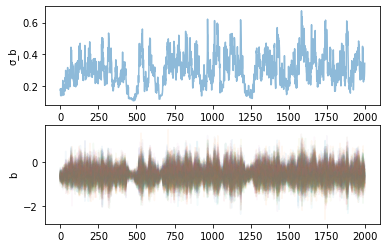

In [12]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_trace.posterior.σ_b.sel({"chain": 0}), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(varying_slope_trace.posterior.b.sel({"chain": 0}), alpha=.05);
axs[1].set(ylabel='b');

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

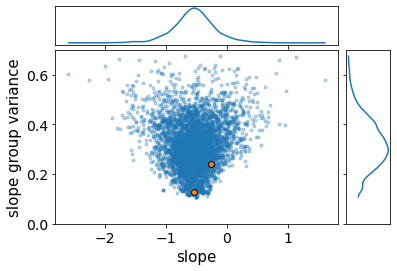

In [13]:
with varying_slope:
    _, ax, *_ = az.plot_pair(
        varying_slope_trace,
        var_names=["b", "σ_b"],
        coords={"County": counties[10]},
        divergences=True,
        marginals=True,
        scatter_kwargs={"alpha": 0.3},
    )
ax[0].set_ylim([0, 0.7])
ax[0].set_xlabel("slope")
ax[0].set_ylabel("slope group variance");

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

The `plot_parallel` function in the ArViZ library is a convenient way to identify patterns in divergent traces:

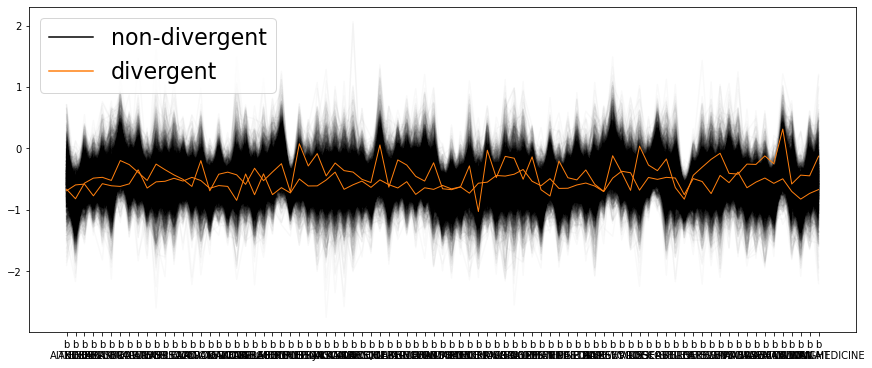

In [14]:
az.plot_parallel(varying_slope_trace, var_names=['b'], figsize=(12,5));

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model.

### Solution: Non-centered Parameterization

The partial pooling model specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. 

Here is the DAG of this centered model:

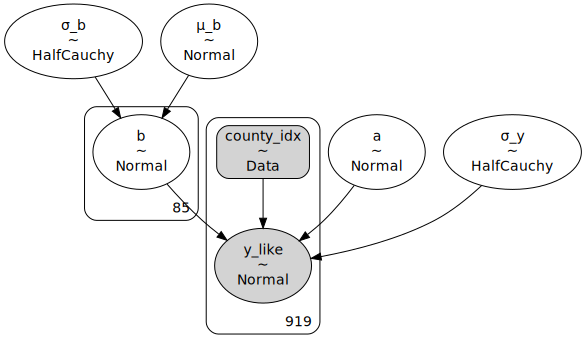

In [15]:
pm.model_to_graphviz(varying_slope)

We can remove the issue with sampling geometry by **reparameterizing** our model:

In [16]:
with pm.Model(coords=coords) as varying_slope_noncentered:
    
    # Priors
    μ_b = pm.Normal('μ_b', mu=0., sigma=10)
    σ_b = pm.HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = pm.Normal('a', mu=0., sigma=10)
    
    # Non-centered random slopes
    # Centered: b = Normal('b', μ_b, sigma=σ_b, dims=["County"])
    υ = pm.Normal('υ', mu=0, sigma=1, dims=["County"])
    b = pm.Deterministic("b", μ_b + υ * σ_b, dims="County")
    
    # Model error
    σ_y =pm.HalfCauchy('σ_y',5)
    
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    
    # Expected value
    y_hat = a + b[county_idx] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal(
        'y_like', mu=y_hat, sigma=σ_y, observed=log_radon, dims="obs_id"
    )

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

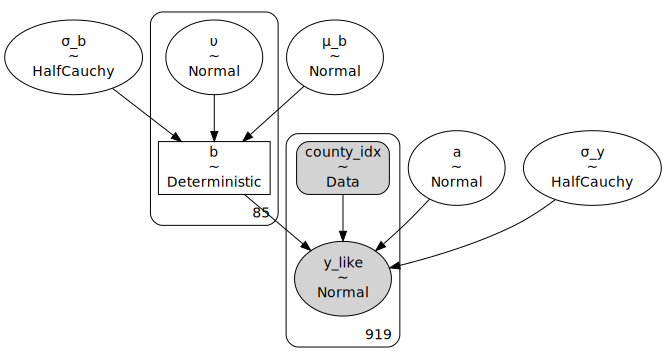

In [17]:
pm.model_to_graphviz(varying_slope_noncentered)

This model samples much better.

In [18]:
with varying_slope_noncentered:
    noncentered_trace = pm.sample(
        2000, tune=1000, cores=2, random_seed=RANDOM_SEED, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_y, υ, a, σ_b, μ_b]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


0, dim: obs_id, 919 =? 919


The number of effective samples is smaller than 25% for some parameters.


Notice that the bottlenecks in the traces are gone.

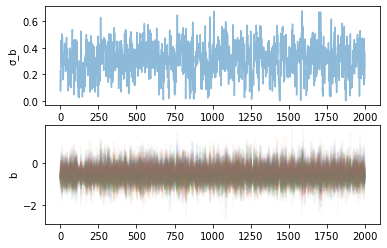

In [19]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.σ_b.sel({"chain": 0}), alpha=.5);
axs[0].set(ylabel='σ_b');
axs[1].plot(noncentered_trace.posterior.b.sel({"chain": 0}), alpha=.05);
axs[1].set(ylabel='b');

And, we are now fully exploring the support of the posterior.

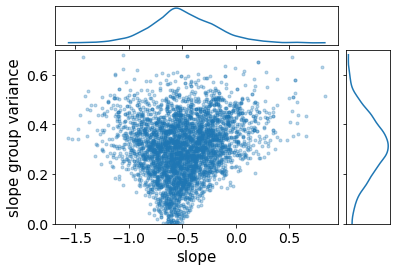

In [20]:
with varying_slope_noncentered:
    _, ax, *_ = az.plot_pair(
        noncentered_trace,
        var_names=["b", "σ_b"],
        coords={"County": counties[75]},
        divergences=True,
        marginals=True,
        scatter_kwargs={"alpha": 0.3},
    )
ax[0].set_ylim([0, 0.7])
ax[0].set_xlabel("slope")
ax[0].set_ylabel("slope group variance");

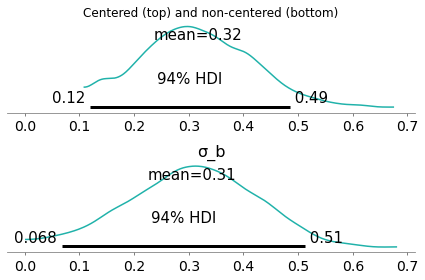

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
az.plot_posterior(varying_slope_trace, var_names=['σ_b'], ax=ax1, color='LightSeaGreen')
az.plot_posterior(noncentered_trace, var_names=['σ_b'], ax=ax2, color='LightSeaGreen')
ax1.set_title('Centered (top) and non-centered (bottom)')
plt.tight_layout()

## Potential Scale Reduction: $\hat{R}$

Roughly, $\hat{R}$ (*R-Hat*, or the *Gelman-Rubin statistic*) is the ratio of between-chain variance to within-chain variance. This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.

$\hat{R}$ uses an analysis of variance approach to assessing convergence. That is, it calculates both the between-chain variance (B) and within-chain variance (W), and assesses whether they are different enough to worry about convergence. Assuming $m$ chains, each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each chain, this quantity will overestimate the true marginal posterior variance. At the same time, $W$ will tend to underestimate the within-chain variance early in the sampling run. However, in the limit as $n \rightarrow \infty$, both quantities will converge to the true variance of $\theta$. In light of this, $\hat{R}$ monitors convergence using the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the **potential scale reduction**, since it is an estimate of the potential reduction in the scale of $\theta$ as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$ close to one (say, less than 1.1) to be confident that a particular estimand has converged. 

In ArViZ, the `summary` table, or a `plot_forest` with the `r_hat` flag set, will calculate $\hat{R}$ for each stochastic node in the trace.

In [22]:
az.summary(pku_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_int,99.786,2.348,95.759,104.336,0.373,0.266,39.0,102.0,1.03
β_0[0],106.161,3.987,99.750,113.766,0.991,0.716,17.0,71.0,1.10
β_0[1],102.660,2.514,98.011,106.804,0.770,0.560,11.0,62.0,1.17
β_0[2],106.278,2.486,101.739,111.254,0.588,0.424,18.0,74.0,1.06
β_0[3],97.621,4.402,90.112,104.754,1.171,0.846,15.0,25.0,1.26
β_0[4],101.617,3.214,95.919,107.409,1.547,1.178,5.0,12.0,1.38
β_0[5],97.576,2.790,92.464,102.523,1.184,0.886,6.0,66.0,1.32
β_0[6],105.332,2.949,100.264,111.175,0.601,0.430,23.0,52.0,1.17
β_0[7],96.586,2.655,92.169,102.558,1.084,0.809,6.0,32.0,1.25
β_0[8],92.753,3.307,86.907,99.097,1.550,1.175,5.0,38.0,1.39


### Exercise

Clearly the model above has not yet converged (we only ran it for 100 iterations without tuning, after all). Try running the `pku_model` for a larger number of iterations, and see when $\hat{R}$ converges to 1.0.

In [23]:
# Write your answer here

## Effective Sample Size

In general, samples drawn from MCMC algorithms will be autocorrelated. Unless the autocorrelation is very severe, this is not a big deal, other than the fact that autocorrelated chains may require longer sampling in order to adequately characterize posterior quantities of interest. The calculation of autocorrelation is performed for each lag $i=1,2,\ldots,k$ (the correlation at lag 0 is, of course, 1) by: 

$$\hat{\rho}_i = 1 - \frac{V_i}{2\hat{\text{Var}}(\theta | y)}$$

where $\hat{\text{Var}}(\theta | y)$ is the same estimated variance as calculated for the potential scale reduction statistic, and $V_i$ is the variogram at lag $i$ for $\theta$:

$$\text{V}_i = \frac{1}{m(n-i)}\sum_{j=1}^m \sum_{k=i+1}^n (\theta_{jk} - \theta_{j(k-i)})^2$$

This autocorrelation can be visualized using the `plot_autocorr` function in ArViZ:

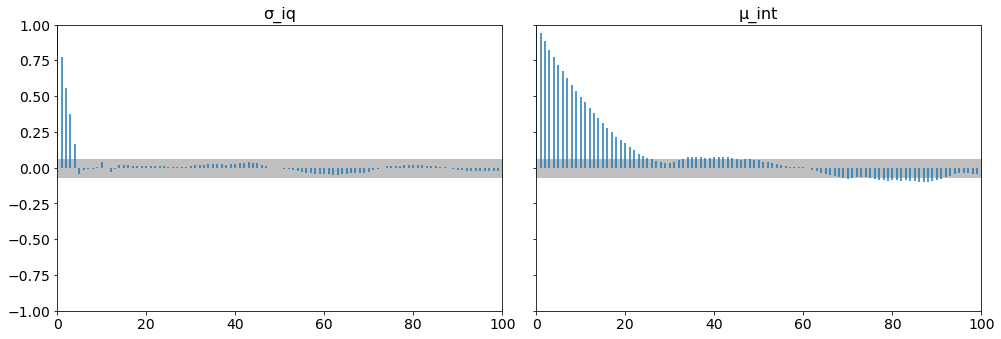

In [24]:
az.plot_autocorr(pku_trace, var_names=['σ_iq', 'μ_int'], combined=True);

You can see very severe autocorrelation in `μ_int`, which is not surprising given the trace that we observed earlier.

The amount of correlation in an MCMC sample influences the **effective sample size** (ESS) of the sample. The ESS estimates how many *independent* draws contain the same amount of information as the *dependent* sample obtained by MCMC sampling.

Given a series of samples $x_j$, the empirical mean is

$$
\hat{\mu} = \frac{1}{n}\sum_{j=1}^n x_j
$$

and the variance of the estimate of the empirical mean is 

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n},
$$
where $\sigma^2$ is the true variance of the underlying distribution.

Then the effective sample size is defined as the denominator that makes this relationship still be true:

$$
\operatorname{Var}(\hat{\mu}) = \frac{\sigma^2}{n_{\text{eff}}}.
$$

The effective sample size is estimated using the partial sum:

$$\hat{n}_{eff} = \frac{mn}{1 + 2\sum_{i=1}^T \hat{\rho}_i}$$

where $T$ is the first odd integer such that $\hat{\rho}_{T+1} + \hat{\rho}_{T+2}$ is negative.

The issue here is related to the fact that we are **estimating** the effective sample size from the fit output. Values of $n_{eff} / n_{iter} < 0.001$ indicate a biased estimator, resulting in an overestimate of the true effective sample size.

Vehtari *et al* (2019) recommend an ESS of at least 400 to ensure reliable estimates of variances and autocorrelations. They also suggest running at least 4 chains before calculating any diagnostics.

Its important to note that ESS can vary across the quantiles of the MCMC chain being sampled. 

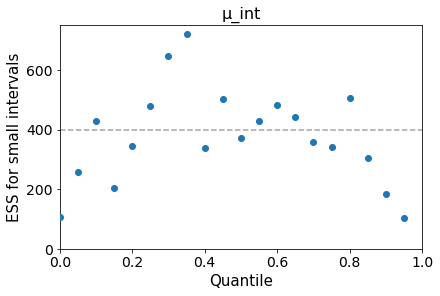

In [25]:
az.plot_ess(pku_trace, var_names=['μ_int']);

Using ArViZ, we can visualize the evolution of ESS as the MCMC sample accumulates. When the model is converging properly, both lines in this plot should be approximately linear.

The standard ESS estimate, which mainly assesses how well the centre of the distribution is resolved, is referred to as **bulk-ESS**. In order to estimate intervals reliably, it is also important to consider the **tail-ESS**.

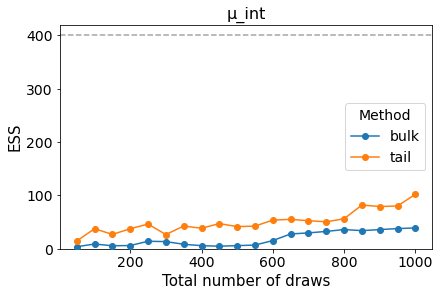

In [26]:
az.plot_ess(pku_trace, var_names=['μ_int'], kind='evolution');

ESS statistics can also be tabulated, by generating a `summary` of the parameters of interest.

In [27]:
az.summary(pku_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_int,99.786,2.348,95.759,104.336,0.373,0.266,39.0,102.0,1.03
β_0[0],106.161,3.987,99.750,113.766,0.991,0.716,17.0,71.0,1.10
β_0[1],102.660,2.514,98.011,106.804,0.770,0.560,11.0,62.0,1.17
β_0[2],106.278,2.486,101.739,111.254,0.588,0.424,18.0,74.0,1.06
β_0[3],97.621,4.402,90.112,104.754,1.171,0.846,15.0,25.0,1.26
β_0[4],101.617,3.214,95.919,107.409,1.547,1.178,5.0,12.0,1.38
β_0[5],97.576,2.790,92.464,102.523,1.184,0.886,6.0,66.0,1.32
β_0[6],105.332,2.949,100.264,111.175,0.601,0.430,23.0,52.0,1.17
β_0[7],96.586,2.655,92.169,102.558,1.084,0.809,6.0,32.0,1.25
β_0[8],92.753,3.307,86.907,99.097,1.550,1.175,5.0,38.0,1.39


It is tempting to want to **thin** the chain to eliminate the autocorrelation (*e.g.* taking every 20th sample from traces with autocorrelation as high as 20), but this is a waste of time. Since thinning deliberately throws out the majority of the samples, no efficiency is gained; you ultimately require more samples to achive a particular desired sample size. 

## Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies **how well momentum resampling matches the marginal energy distribution**. 

$$\text{BFMI} = \frac{\mathbb{E}_{\pi}[\text{Var}_{\pi_{E|q}}(E|q)]}{\text{Var}_{\pi_{E}}(E)}$$

$$\widehat{\text{BFMI}} = \frac{\sum_{i=1}^N (E_n - E_{n-1})^2}{\sum_{i=1}^N (E_n - \bar{E})^2}$$

A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to *efficiently* explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal. Reparameterizing the model is sometimes helpful for improving this statistic.

BFMI calculation is only available in samples that were simulated using HMC or NUTS.

In [28]:
with pku_model:

    pku_trace = pm.sample(return_inferencedata=True, random_seed=RANDOM_SEED)
    az.bfmi(pku_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_iq, β_2, β_1, β_0, σ_int, μ_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


Another way of diagnosting this phenomenon is by comparing the overall distribution of 
energy levels with the *change* of energy between successive samples. Ideally, they should be very similar.

If the distribution of energy transitions is narrow relative to the marginal energy distribution, this is a sign of inefficient sampling, as many transitions are required to completely explore the posterior. On the other hand, if the energy transition distribution is similar to that of the marginal energy, this is evidence of efficient sampling, resulting in near-independent samples from the posterior.

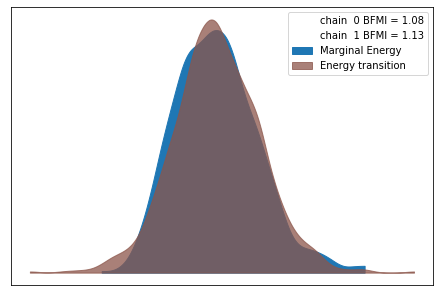

In [29]:
az.plot_energy(pku_trace);

## Goodness of Fit

As noted at the beginning of this section, convergence diagnostics are only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model to converge, so additional steps are needed to ensure that the estimated model adequately fits the data. 

One intuitive way of evaluating model fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate data, and the distribution of the simulated data should resemble the distribution of the actual data.

Fortunately, simulating data from the model is a natural component of the Bayesian modelling framework. Recall, from the discussion on prediction, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be expected, taking into account the posterior uncertainty in the model parameters. 

Sampling from the posterior predictive distribution is easy in PyMC3. The `sample_posterior_predictive` function draws posterior predictive samples from all of the observed variables in the model. Consider the PKU model, 
where IQ is modeled as a Gaussian random variable, which is thought to be influenced by blood Phe levels.

The posterior predictive distribution of IQ uses the same functional form as the data likelihood, in this case a normal stochastic. Here is the corresponding sample from the posterior predictive distribution (we typically need very few samples relative to the MCMC sample):

In [30]:
with pku_model:
    pku_ppc = pm.sample_posterior_predictive(pku_trace.posterior, samples=500)

The degree to which simulated data correspond to observations can be evaluated visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution.

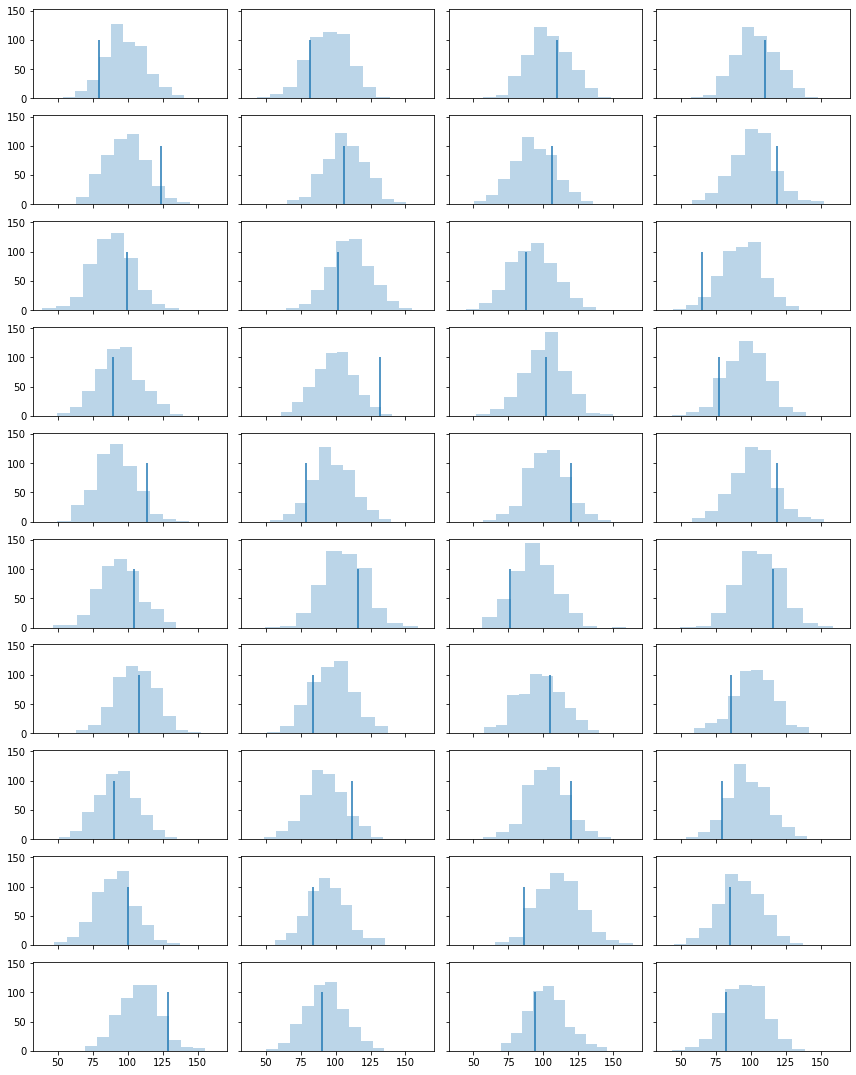

In [31]:
fig, axes = plt.subplots(10, 4, figsize=(12,15), sharex=True, sharey=True)

for ax in axes.ravel():
    i = np.random.randint(0, pku_ppc['iq_like'].shape[1])
    ax.hist(pku_ppc['iq_like'][:, i], alpha=0.3)
    ax.vlines(iq[i], 0, 100)

plt.tight_layout();

A quantitative approach is to calculate quantiles of each observed data point relative to the corresponding distribution of posterior-simulated values. For an adequate fit, there should not be severe peaks in the histogram near zero and one.

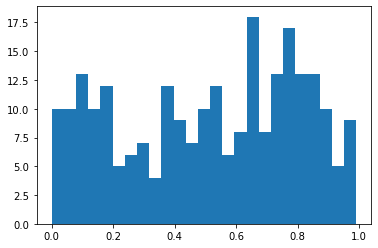

In [32]:
from scipy.stats import percentileofscore

plt.hist([np.round(percentileofscore(x, y)/100, 2) for x,y in zip(pku_ppc['iq_like'], iq)], bins=25);

---

## References

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

[Vehtari, Gelman, Simpson, Carpenter, Bürkner (2019)](https://arxiv.org/abs/1903.08008) Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC